In [1]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

In [2]:
# Reading & Cleaning sub indicators
Sub=pd.read_excel('sub_indicators_081421.xlsx')
Sub.index=Sub['province']
Sub.drop('province',axis='columns',inplace=True)



In [3]:
def Standardize(Ser):
    result=(Ser-Ser.mean())/Ser.std()
    return result

ind_type=pd.read_excel(r'D:\Personal\University\Master\Thesis\Aggregation-Weighting\indicator_type.xlsx',sheet_name='Sheet1')
ind_type.drop('pop_growth',axis=1,inplace=True)
ind_type.drop([0,1],axis=0,inplace=True)
ind_type['withdraw_gw_ratio']='l'
ind_type['damcap_rwr_ratio']='b'
ind_type.index=['type']

Standardized_data=pd.DataFrame(index=Sub.index)
for col in Sub.columns:
    if ind_type.loc['type',col]=='b':
        Standardized_data[col]=Standardize(Sub.loc[:,col])
    else:
        Standardized_data[col]=Standardize(-Sub.loc[:,col])    
res_sub_columns=['ACV','MCV','Dag','Dan','GWDagr','GWDind','GWDurb','GWDrur','SWS','GWS','APA','ATA','IRWR']
acc_sub_columns=['WAurb','WArur','USP','SAurb','SArur','TPC','WQ','DC']
eco_sub_columns=['AE','MI','EL','NRWurb','NRWrur','IE']
sub_columns=res_sub_columns+acc_sub_columns+eco_sub_columns 
Standardized_data.columns=sub_columns

In [4]:
# Reading Normalized indicators based on Phillis method
Normalized_main=pd.read_excel('Normalized Sub Indicators.xlsx')
Normalized_main.drop(1,axis='index',inplace=True)
Normalized_main.columns=Normalized_main.iloc[0,:]
Normalized_main.drop(0,axis='index',inplace=True)
Normalized_main.rename({'Indicator':'province'},axis='columns',inplace=True)
Normalized_main.index=Normalized_main['province']
Normalized_main.drop('province',axis='columns',inplace=True)
sub_columns1_list= ['R1','R1','R2','R2','R3','R3','R3','R3','R4','R4','R5','R5','R7']+['A1','A1','A1','A2','A2','A2','A3','A3']+['E1','E1','E1','E2','E2','E3']
sub_columns2_list=list(Normalized_main.columns)

In [5]:
arrayeco=['E1','E1','E1','E2','E2','E3','E3','E3']
arrayacc=['A1','A1','A1','A2','A2','A2','A3','A3','A3','A3']
arrayres=['R1','R1','R2','R2','R3','R3','R3','R3','R4','R4','R5','R5','R5','R6','R6','R7','R7','R7','R7']
arraywsi=['WSI','WSI','WSI']
Agg_lvl=arraywsi+arrayres+arrayacc+arrayeco

In [6]:
#PCA weights df
PCA_weights=pd.read_csv('PCA_weights.csv')
PCA_weights.drop('Unnamed: 0',axis=1,inplace=True)
multi_columns=[Agg_lvl]+[list(PCA_weights.iloc[0])]
PCA_weights.columns=pd.MultiIndex.from_arrays(multi_columns, names=('Aggregation Level', 'Indicator'))
PCA_weights.drop(0,inplace=True)
PCA_weights.index=['weights']
PCA_weights=PCA_weights.astype('float')
PCA_weights['E3']

Indicator,Eagr,NRW,IP
weights,0.1467,0.3962,0.4571


In [7]:
#AHP weights df
AHP_weights=pd.read_csv('AHP_weights.csv')
AHP_weights.drop('Aggregation Level',axis=1,inplace=True)
multi_columns=[Agg_lvl]+[list(AHP_weights.iloc[0])]
AHP_weights.columns=pd.MultiIndex.from_arrays(multi_columns, names=('Aggregation Level', 'Indicator'))
AHP_weights.drop(0,inplace=True)
AHP_weights.index=['weights']
AHP_weights=AHP_weights.astype('float')

In [8]:
#Equal weights df
Equal_weights=AHP_weights*0
agg=set(Agg_lvl)
for col in agg:
    size=Equal_weights[col].size
    Equal_weights[col]=1/size
Equal_weights=Equal_weights.round(decimals=2)
Equal_weights=Equal_weights.astype('float')

In [9]:
# Defining Aggregation Method
def weighted_agg(dfi,dfw,method='addgeo',a=0.5):
    weight_array=np.array(dfw)[0]
    dfmin=dfi.min(axis=1)
    weighted_sum=dfi.multiply(weight_array,axis='columns').sum(axis=1)
    weighted_geomean=dfi.pow(weight_array,axis='columns').product(axis='columns')
    if method=='addgeo':
        result= a*weighted_geomean+(1-a)*weighted_sum
    elif method=='addmin':
        result=a*dfmin+(1-a)*weighted_sum
    elif method=='geomin':
        result=a*dfmin+(1-a)*weighted_geomean
    return result

In [10]:
# changing columns into multi index
arraycolumns=[sub_columns1_list]+[sub_columns2_list]
Normalized_main.columns=pd.MultiIndex.from_arrays(arraycolumns, names=('Aggregation Level', 'Indicator'))
Standardized_data.columns=pd.MultiIndex.from_arrays(arraycolumns, names=('Aggregation Level', 'Indicator'))


In [11]:
def WSI_df(normalized_df,standardized_df,AHP_df,PCA_df,Equal_df,weighting='AHP',aggmethod='addmin',scaling='normalize', a=0.5):
    if weighting=='AHP':
        weights_df=AHP_df
    elif weighting=='PCA':
        weights_df=PCA_df
    elif weighting=='Equal':
        weights_df=Equal_df
        
    if scaling=='normalize':
        data=normalized_df
    elif scaling=='standardize':
        data=standardized_df    
    
    Scaled_lvl2=pd.DataFrame(normalized_df[('R4','SWS')]*0,index=normalized_df.index)
    Scaled_lvl2.columns=pd.MultiIndex.from_arrays([['R5'],['CV']], names=('Aggregation Level', 'Indicator'))
    Scaled_lvl2[('R5','CV')]=weighted_agg(normalized_df.loc[:,'R1'],weights_df['R1'],aggmethod,a).round(decimals=4)
    Scaled_lvl2[('R6','GD')]=weighted_agg(normalized_df.loc[:,'R2'],weights_df['R2'],aggmethod,a).round(decimals=4)
    Scaled_lvl2[('R6','GWD')]=weighted_agg(normalized_df.loc[:,'R3'],weights_df['R3'],aggmethod,a).round(decimals=4)

    indicators=pd.DataFrame(data[('R4','SWS')]*0,index=data.index)
    indicators.columns=pd.MultiIndex.from_arrays([['Resource'],['IRWR']], names=('Dimension', 'Indicator'))
    indicators[('Resource','IRWR')]=data.loc[:,('R7','IRWR')]
    indicators[('Resource','CC')]=weighted_agg(Scaled_lvl2['R5'].merge(data['R5'], left_index=True, right_index=True,how='outer'),weights_df['R5'],aggmethod,a).round(decimals=4)
    indicators[('Resource','WS')]=weighted_agg(data.loc[:,'R4'],weights_df['R4'],aggmethod,a).round(decimals=4)
    indicators.loc[Scaled_lvl2[('R6','GD')]<0.8,('Resource','GW')]=weighted_agg(Scaled_lvl2.loc[:,'R6'],weights_df['R6'],aggmethod,a).round(decimals=4)
    indicators.loc[Scaled_lvl2[('R6','GD')]>0.8,('Resource','GW')]=Scaled_lvl2.loc[:,('R6','GD')]
    indicators[('Access','DW')]=weighted_agg(normalized_df.loc[:,'A1'],weights_df['A1'],aggmethod,a).round(decimals=4)
    indicators[('Access','WQ')]=data.loc[:,('A3','WQ')]
    indicators[('Access','DC')]=data.loc[:,('A3','DC')]
    indicators[('Access','SS')]=weighted_agg(data.loc[:,'A2'],weights_df['A2'],aggmethod,a).round(decimals=4)
    indicators[('Economy','Eagr')]=weighted_agg(data.loc[:,'E1'],weights_df['E1'],aggmethod,a).round(decimals=4)
    indicators[('Economy','IE')]=data.loc[:,('E3','IE')]
    indicators[('Economy','NRW')]=weighted_agg(data.loc[:,'E2'],weights_df['E2'],aggmethod,a).round(decimals=4)
    Dimensions=pd.DataFrame(index=data.index)
    Dimensions['Resource']=weighted_agg(indicators[('Resource')],weights_df['R7'],aggmethod,a).round(decimals=4)
    Dimensions['Access']=weighted_agg(indicators[('Access')],weights_df['A3'],aggmethod,a).round(decimals=4)
    Dimensions['Economy']=weighted_agg(indicators[('Economy')],weights_df['E3'],aggmethod,a).round(decimals=4)
    Dimensions['WSI']=weighted_agg(Dimensions,weights_df['WSI'],aggmethod,a).round(decimals=4)
    return Dimensions


In [18]:
comparison_index=list(Normalized_main.index)+['Aggregation_method','Weighting_method','Scaling_method','alpha']
WSI_methods=pd.DataFrame(index=comparison_index)
# def WSI_df(normalized_df,standardized_df,AHP_df,PCA_df,Equal_df,weighting='AHP',aggmethod='addmin',scaling='normalize', a=0.5)

for agg in ['addmin','addgeo','geomin']:
    for alpha in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        for scale in ['normalize','standardize']:
            for weight in ['AHP','PCA','Equal']:
                if (agg=='addmin' and alpha == 1) or (agg=='geomin' and alpha == 1) or (agg=='addmin' and alpha == 0):
                    pass
                else:
                    name=agg+"_"+weight+'_'+scale+'_'+str(alpha)
                    WSI_methods.loc['azsh':'yazd',name]=WSI_df(Normalized_main,Standardized_data,AHP_weights,PCA_weights,Equal_weights,weighting=weight,aggmethod=agg,scaling=scale,a=alpha)['WSI']
                    WSI_methods.loc['Aggregation_method',name]=agg
                    WSI_methods.loc['Weighting_method',name]=weight
                    WSI_methods.loc['Scaling_method',name]=scale
                    WSI_methods.loc['alpha',name]=alpha
WSI_ranks=WSI_methods.loc['azsh':'yazd',:].rank(ascending=False)

In [ ]:
# agg_cond1=(WSI_methods.loc['Aggregation_method',:]=='addmin') & (WSI_methods.loc['alpha',:]!=0)
# addmin_avg_change=(WSI_ranks.loc[:,agg_cond1].max(axis=1)-WSI_ranks.loc[:,agg_cond1].min(axis=1)).mean()
# agg_cond2=(WSI_methods.loc['Aggregation_method',:]=='addgeo') & (WSI_methods.loc['alpha',:]==0)
# add_avg_change=(WSI_ranks.loc[:,agg_cond2].max(axis=1)-WSI_ranks.loc[:,agg_cond2].min(axis=1)).mean()
# agg_cond3=(WSI_methods.loc['Aggregation_method',:]=='addgeo') & (WSI_methods.loc['alpha',:]==1)
# geo_avg_change=(WSI_ranks.loc[:,agg_cond3].max(axis=1)-WSI_ranks.loc[:,agg_cond3].min(axis=1)).mean()
# agg_cond4=(WSI_methods.loc['Aggregation_method',:]=='addgeo') & (WSI_methods.loc['alpha',:]!=1) & (WSI_methods.loc['alpha',:]!=0)
# addgeo_avg_change=(WSI_ranks.loc[:,agg_cond4].max(axis=1)-WSI_ranks.loc[:,agg_cond4].min(axis=1)).mean()

# weight_cond1=WSI_methods.loc['Weighting_method',:]=='AHP'
# AHP_avg_change=(WSI_ranks.loc[:,weight_cond1].max(axis=1)-WSI_ranks.loc[:,weight_cond1].min(axis=1)).mean()
# AHP_avg_change

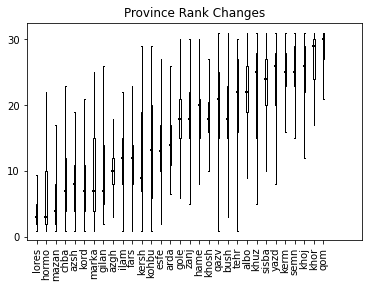

In [16]:
import matplotlib.pyplot as plt
WSI_ranks['Mean']=WSI_ranks.mean(axis=1)
df=WSI_ranks.sort_values('Mean').transpose()
fig, ax = plt.subplots()
plt.cla()
plt.rcParams["figure.figsize"] = (16,9)
ax.set_title('Province Rank Changes')
medianprops = dict(linestyle='-', linewidth=2, color='black')
ax.boxplot(df, showfliers=False,widths=0.13,labels=df.columns,medianprops =medianprops)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 18})
ax.set_xlim(0,35)
# plt.savefig('Rank Changes Closer(0.1 intervals).png')
plt.show()

In [17]:
temp=pd.DataFrame(index=WSI_ranks.index)
temp['First_Quartile']=0
temp['Third_Quartile']=0
for i in temp.index:
    temp.loc[i,'First_Quartile']=(np.percentile(WSI_ranks.loc[i,:], 25)).astype(int)
    temp.loc[i,'Third_Quartile']=(np.percentile(WSI_ranks.loc[i,:], 75)).astype(int)
temp['IQR']=(temp['Third_Quartile']-temp['First_Quartile'])
temp['Upper_Limit']=(temp['Third_Quartile']+1.5*temp['IQR']).astype(int)
temp['Lower_Limit']=(temp['First_Quartile']-1.5*temp['IQR']).astype(int)
temp.loc[temp['Lower_Limit']<1,'Lower_Limit']=1
temp.loc[temp['Upper_Limit']>31,'Upper_Limit']=31

WSI_ranks['Maximum']=WSI_ranks.max(axis=1)
WSI_ranks['Minimum']=WSI_ranks.min(axis=1)
WSI_ranks['Mean']=WSI_ranks.mean(axis=1)
WSI_ranks['Median']=WSI_ranks.median(axis=1)
WSI_ranks=WSI_ranks.astype(int)
for i in WSI_ranks.columns:
    WSI_ranks.loc[WSI_ranks.loc[:,i]>temp['Upper_Limit'],i]=temp['Upper_Limit']
    WSI_ranks.loc[WSI_ranks.loc[:,i]<temp['Lower_Limit'],i]=temp['Lower_Limit']
temp['Upper_Limit']-temp['Lower_Limit']

azsh     20
azgh     16
arda     24
esfe     26
albo     23
ilam     24
bush     28
tehr     30
chba     23
khoj     20
khor     16
khosh    16
khuz     30
zanj     27
semn     17
sisba    22
fars     22
qazv     30
qom      10
kord     20
kerm     16
kersh    30
kohbu    30
gole     24
gilan    26
lores     8
mazan    16
marka    30
hormo    21
hame     24
yazd     23
dtype: int32

In [46]:
WSI_ranks['Maximum']

azsh     21
azgh     18
arda     26
esfe     29
albo     31
ilam     25
bush     31
tehr     30
chba     24
khoj     31
khor     31
khosh    26
khuz     31
zanj     30
semn     31
sisba    31
fars     23
qazv     31
qom      31
kord     21
kerm     31
kersh    29
kohbu    29
gole     30
gilan    26
lores     9
mazan    17
marka    25
hormo    22
hame     30
yazd     31
Name: Maximum, dtype: int32

In [47]:
WSI_ranks['Mean']

azsh      8
azgh     10
arda     14
esfe     13
albo     21
ilam     11
bush     19
tehr     20
chba      8
khoj     24
khor     26
khosh    18
khuz     22
zanj     18
semn     24
sisba    23
fars     12
qazv     18
qom      27
kord      8
kerm     24
kersh    12
kohbu    13
gole     17
gilan     9
lores     3
mazan     5
marka     8
hormo     5
hame     18
yazd     23
Name: Mean, dtype: int32

In [48]:
WSI_ranks['Median']

azsh      8
azgh     10
arda     14
esfe     13
albo     22
ilam     12
bush     18
tehr     22
chba      7
khoj     26
khor     29
khosh    18
khuz     25
zanj     18
semn     25
sisba    24
fars     12
qazv     21
qom      30
kord      7
kerm     25
kersh     9
kohbu    13
gole     18
gilan     7
lores     3
mazan     4
marka     7
hormo     3
hame     20
yazd     26
Name: Median, dtype: int32

In [50]:
WSI_ranks['Maximum']-WSI_ranks['Minimum']

azsh     20
azgh     15
arda     20
esfe     27
albo     25
ilam     24
bush     28
tehr     29
chba     23
khoj     20
khor     16
khosh    16
khuz     26
zanj     26
semn     17
sisba    22
fars     22
qazv     30
qom      10
kord     20
kerm     16
kersh    28
kohbu    28
gole     24
gilan    24
lores     8
mazan    16
marka    24
hormo    21
hame     24
yazd     23
dtype: int32